# Autoencoder 

Source: https://blog.keras.io/building-autoencoders-in-keras.html

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

1) Autoencoders are data-specific, which means that they will only be able to compress data similar to what they have been trained on. This is different from, say, the MPEG-2 Audio Layer III (MP3) compression algorithm, which only holds assumptions about "sound" in general, but not about specific types of sounds. An autoencoder trained on pictures of faces would do a rather poor job of compressing pictures of trees, because the features it would learn would be face-specific.

2) Autoencoders are lossy, which means that the decompressed outputs will be degraded compared to the original inputs (similar to MP3 or JPEG compression). This differs from lossless arithmetic compression.

3) Autoencoders are learned automatically from data examples, which is a useful property: it means that it is easy to train specialized instances of the algorithm that will perform well on a specific type of input. It doesn't require any new engineering, just appropriate training data.

To build an autoencoder, you need three things: an encoding function, a decoding function, and a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function). The encoder and decoder will be chosen to be parametric functions (typically neural networks), and to be differentiable with respect to the distance function, so the parameters of the encoding/decoding functions can be optimize to minimize the reconstruction loss, using Stochastic Gradient Descent. It's simple! And you don't even need to understand any of these words to start using autoencoders in practice.

Today two interesting practical applications of autoencoders are **data denoising** (which we feature later in this post), and **dimensionality reduction for data visualization**. With appropriate dimensionality and sparsity constraints, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.

For 2D visualization specifically, t-SNE (pronounced "tee-snee") is probably the best algorithm around, but it typically requires relatively low-dimensional data. So a good strategy for visualizing similarity relationships in high-dimensional data is to start by using an autoencoder to compress your data into a low-dimensional space (e.g. 32 dimensional), then use t-SNE for mapping the compressed data to a 2D plane. Note that a nice parametric implementation of t-SNE in Keras was developed by Kyle McDonald and is available on Github. Otherwise scikit-learn also has a simple and practical implementation.

Random Points:
- a potential avenue for solving the problem of unsupervised learning, i.e. the learning of useful representations without the need for labels.
- they are a self-supervised technique, a specific instance of supervised learning where the targets are generated from the input data.
- jigsaw puzzle solving, or detail-context matching (being able to match high-resolution but small patches of pictures with low-resolution versions of the pictures they are extracted from).
 


## Let's build the simplest possible autoencoder

## We'll start simple, with a single fully-connected neural layer as encoder and as decoder:



In [46]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
print(input_img)

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
print("encoded:", encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)
print("decoded:", decoded)

Tensor("input_35:0", shape=(?, 784), dtype=float32)
encoded: Tensor("dense_22/Relu:0", shape=(?, 32), dtype=float32)
decoded: Tensor("dense_23/Sigmoid:0", shape=(?, 784), dtype=float32)


In [47]:
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_23 (Dense)             (None, 784)               25872     
Total params: 50,992.0
Trainable params: 50,992.0
Non-trainable params: 0.0
_________________________________________________________________
None


In [44]:
'''Encoder Model'''
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
print("encoder model: ")
print(encoder.summary())

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
print("\nencoded input: ",encoded_input)

encoder model: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                25120     
Total params: 25,120.0
Trainable params: 25,120.0
Non-trainable params: 0.0
_________________________________________________________________
None

encoded input:  Tensor("input_34:0", shape=(?, 32), dtype=float32)


In [48]:
'''Decoder Model'''
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
print("\ndecoded layer",decoder_layer)

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
print("\ndecoder model: ")
print(decoder.summary())


decoded layer <keras.layers.core.Dense object at 0x1147f7ba8>

decoder model: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 32)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 784)               25872     
Total params: 25,872.0
Trainable params: 25,872.0
Non-trainable params: 0.0
_________________________________________________________________
None


In [49]:
# First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_23 (Dense)             (None, 784)               25872     
Total params: 50,992.0
Trainable params: 50,992.0
Non-trainable params: 0.0
_________________________________________________________________
None


In [53]:
'''Train our autoencoder to reconstruct MNIST digits.'''
#Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)
print()

# We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print (x_train.shape)
print (x_test.shape)
print()

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape[1:])
print(x_test.shape[1:])
print()

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)

(60000, 28, 28)
(10000, 28, 28)

(784,)
(784,)

(60000, 784)
(10000, 784)


In [112]:
# Now let's train our autoencoder for 50 epochs:
autoencoder.fit(x_train, x_train,
                epochs=40,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 2s - loss: 0.1896 - val_loss: 0.1845

In [72]:
'''Visualize reconstruction'''
# After 50 epochs, the autoencoder seems to reach a stable train/test loss value of about 0.11. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

print(encoded_imgs.shape)
print(decoded_imgs.shape)

(10000, 32)
(10000, 784)


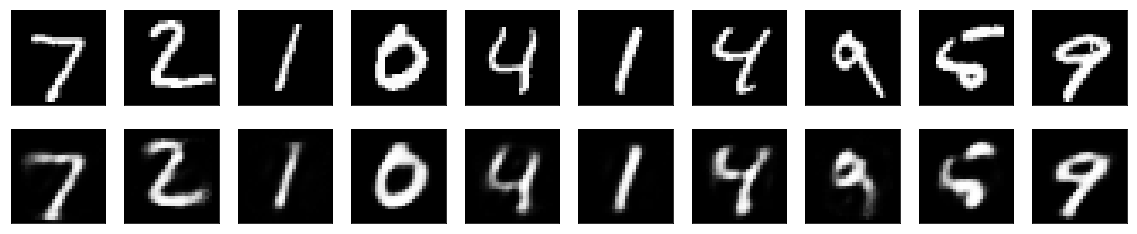

In [9]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

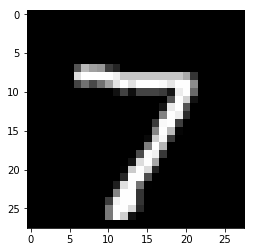

In [73]:
plt.imshow(x_test[0].reshape(28, 28))
plt.show()
plt.close()

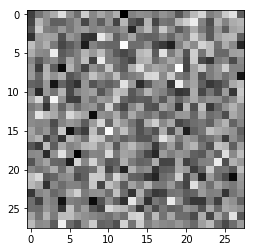

In [83]:
plt.imshow(decoded_imgs[0].reshape(28, 28))
plt.show()
plt.close()

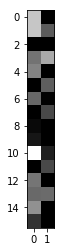

In [109]:
plt.imshow(encoded_imgs[0].reshape((16,2)))
plt.show()
plt.close()

In [108]:
encoded_ex = encoded_imgs[0,:].reshape((16,2))
print(encoded_ex.shape)

decoded_ex = decoded_imgs[0].reshape(28, 28)
print(decoded_ex.shape)

(16, 2)
(28, 28)
